In [1]:
using HDF5

using Plots

include("..\\LiPoSID.jl")

Main.LiPoSID

In [2]:
function read_timeevolution(file_name, state, γ)
    h5open(file_name, "r") do file
        ρᵧ = read(file[state][string(γ)])
        t = ρᵧ["t"]
        ρ₀₀ = ρᵧ["p0"]; Re_ρ₀₁ = ρᵧ["s_re"];  Im_ρ₀₁ = ρᵧ["s_im"]
        ρ_series = []
        t_series = []

        for i in 1:length(t)
            ρᵢ= [ ρ₀₀[i]                      Re_ρ₀₁[i] + im * Im_ρ₀₁[i]
                  Re_ρ₀₁[i] - im * Im_ρ₀₁[i]  1 - ρ₀₀[i]                 ]
            push!(ρ_series, convert(Matrix{ComplexF64}, ρᵢ))
            push!(t_series, convert(Float64, t[i]))
        end
        return(t_series, ρ_series)
    end
end

read_timeevolution (generic function with 1 method)

In [4]:
#γ = [ "0.079477",  "0.25133", "0.79477", "2.5133", "7.9477", "25.133", "79.477", "251.33"]

γ = ["7.9477", "79.477"]

data_file = "../DATA/LONG_GAMMAS_5_7_D4.h5"

t, ρ  = read_timeevolution(data_file, "D1", γ[1])
b = LiPoSID.bloch(ρ)

3×1755 Matrix{Float64}:
 0.0  0.0      0.0       0.0       0.0       …  -1.39356e-6  -1.5009e-6
 0.0  0.0      0.0       0.0       0.0           4.48941e-6   4.04036e-6
 1.0  0.99547  0.986665  0.979271  0.972405      0.875312     0.875311

In [5]:
cummean(A) = cumsum(A) ./ (1:length(A))

function plot_bloch_components(data_file, γ, n)

    # Open the HDF5 file in read mode
    file = h5open(data_file, "r")
    # Read the keys (datasets and groups)
    states = keys(file)
    # Close the file
    close(file)

    t, ρ  = read_timeevolution(data_file, states[1], γ)
    b = LiPoSID.bloch(ρ)
    plt = plot(b[n, :], label=false, xlabel="Time steps", ylabel="Bloch component #"*string(n))

    b_ends = []
    ρ_lens = []
    push!(b_ends, b[end])
    push!(ρ_lens, length(ρ))

    for state in states[2:end]
        t, ρ  = read_timeevolution(data_file, state, γ)
        b = LiPoSID.bloch(ρ)
        push!(b_ends, b[n, end])
        push!(ρ_lens, length(ρ))
        plt = plot!(b[n, :], label=false)
    end

    b_min = minimum(abs.(b_ends))
    b_max = maximum(abs.(b_ends))

    max_len = maximum(ρ_lens)

    plt = hline!([b_min, b_max], linestyle=:dash, color=:black, label=false)
    #plt = hline!([b_max], linestyle=:dash, color=:black, label=false)

    plt = ylims!(-1.1, 1.1)

    plt = annotate!(5*round(max_len/6), (b_min + b_max)/2, text(string(b_max)*" \n"*string(b_min), 10)) 

    plt = title!("γ ="*string(γ))

    return plt
end

function plot_bloch_cummean(data_file, γ, n)

    # Open the HDF5 file in read mode
    file = h5open(data_file, "r")
    # Read the keys (datasets and groups)
    states = keys(file)
    # Close the file
    close(file)

    t, ρ  = read_timeevolution(data_file, states[1], γ)
    b = LiPoSID.bloch(ρ)
    plt = plot(cummean(b[n, :]), label=false, xlabel="Time steps", ylabel="Bloch component #"*string(n))

    b_ends = []
    b_lens = []
    push!(b_ends, b[end])
    push!(b_lens, length(ρ))

    for state in states[2:end]
        t, ρ  = read_timeevolution(data_file, state, γ)
        b = LiPoSID.bloch(ρ)
        push!(b_lens, length(ρ))
        push!(b_ends, b[n, end])
        plt = plot!(cummean(b[n, :]), label=false)
    end

    b_min = minimum(abs.(b_ends))
    b_max = maximum(abs.(b_ends))

    max_len = maximum(b_lens)

    plt = hline!([b_min, b_max], linestyle=:dash, color=:black, label=false)
    #plt = hline!([b_max], linestyle=:dash, color=:black, label=false)

    plt = ylims!(-1.1, 1.1)

    plt = annotate!(5*round(max_len/2), (b_min + b_max)/2, text(string(b_max)*" \n"*string(b_min)), 10) 

    plt = title!("γ ="*string(γ))

    return plt
end


function bloch_ends(data_file, γ, n)

    # Open the HDF5 file in read mode
    file = h5open(data_file, "r")
    # Read the keys (datasets and groups)
    states = keys(file)
    # Close the file
    close(file)

    t, ρ  = read_timeevolution(data_file, states[1], γ)
    b = LiPoSID.bloch(ρ)
    plt = plot(b[n, :], label=false, xlabel="Time steps", ylabel="Bloch component #"*string(n))

    b_ends = []
    push!(b_ends, b[n, end])

    for state in states[2:end]
        t, ρ  = read_timeevolution(data_file, state, γ)
        b = LiPoSID.bloch(ρ)
        push!(b_ends, b[end])
        plt = plot!(b[n, :], label=false)
    end

    b_max = maximum(abs.(b_ends))
    b_min = minimum(abs.(b_ends))

    return b_min, b_max
end

bloch_ends (generic function with 1 method)

In [47]:
γ = ["7.9477", "79.477"]

2-element Vector{String}:
 "7.9477"
 "79.477"

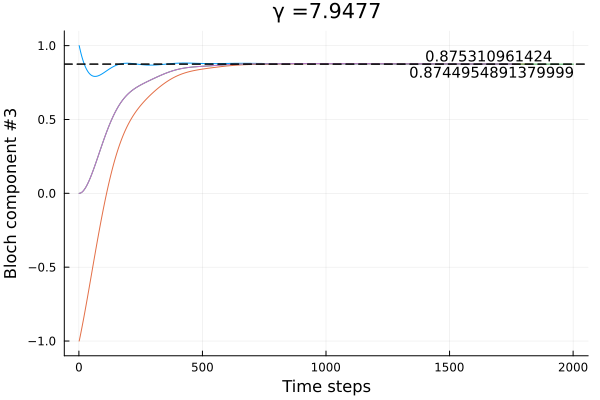

In [44]:
plt = plot_bloch_components("../DATA/LONG_GAMMAS_5_7_D4.h5", γ[1], 3)

In [45]:
savefig(plt, "asymptote_bloch3_gamma_7_long.pdf")

"c:\\Users\\Zakhar\\Documents\\GitHub\\OQSID-thesis\\THERMALIZATION\\asymptote_bloch3_gamma_7_long.png"

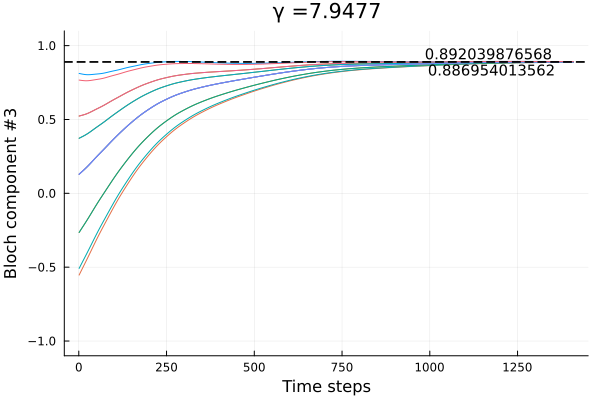

"c:\\Users\\Zakhar\\Documents\\GitHub\\OQSID-thesis\\THERMALIZATION\\asymptote_bloch3_gamma_7.png"

In [46]:
plt = plot_bloch_components("../DATA/ALL_GAMMAS_B4_D10.h5", γ[1], 3)
display(plt)
savefig(plt, "asymptote_bloch3_gamma_7.pdf")

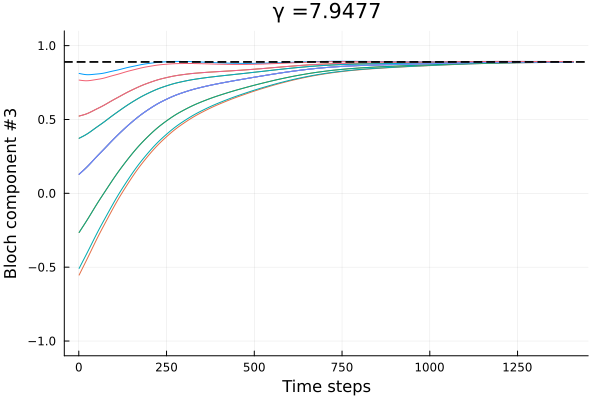

In [27]:
plt = plot_bloch_components("../DATA/ALL_GAMMAS_B4_D10.h5", γ[1], 3)
display(plt)

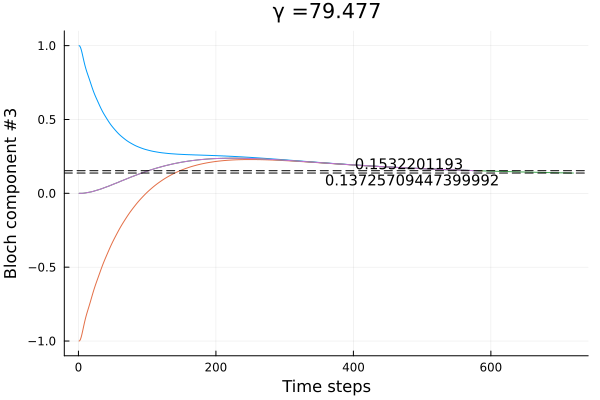

In [20]:
plt = plot_bloch_components("../DATA/LONG_GAMMAS_5_7_D4.h5", γ[2], 3)
display(plt)

In [6]:
γ = [ "0.079477",  "0.25133", "0.79477", "2.5133", "7.9477", "25.133", "79.477", "251.33"]
for γᵢ in γ
    plt = plot_bloch_components("../DATA/ALL_GAMMAS_B4_D10.h5", γᵢ, 3)
    #display(plt)
    savefig(plt, "asymptote_bloch3_gamma_"*γᵢ*".pdf")
end

In [10]:
savefig(plt, "long_gamma_79.png")

"c:\\Users\\Zakhar\\Documents\\GitHub\\OQSID-thesis\\THERMALIZATION\\long_gamma_79.png"

In [10]:
function plot_bloch_ends(data_file, n)

    b_maxs = []
    b_mins = []
    for γᵢ in γ
        b_min, b_max = bloch_ends(data_file, γᵢ, n)
        push!(b_maxs, b_max) 
        push!(b_mins, b_min) 
    end

    plt = plot(b_mins, label=false,  ylim=(0,1.1), marker=:+) #seriestype=:scatter,
    plt = plot!(b_maxs, label=false,  ylim=(0,1.1), marker=:+) #seriestype=:scatter,
    plt = title!("Final state of the evolution")
    plt = ylabel!("Bloch component #"*string(n))
    plt = xlabel!("Coupling, γ")
    plt = xticks!(1:8, γ)
    plt = ylims!(-1.1, 1.1)

    return plt

end


plot_bloch_ends (generic function with 1 method)

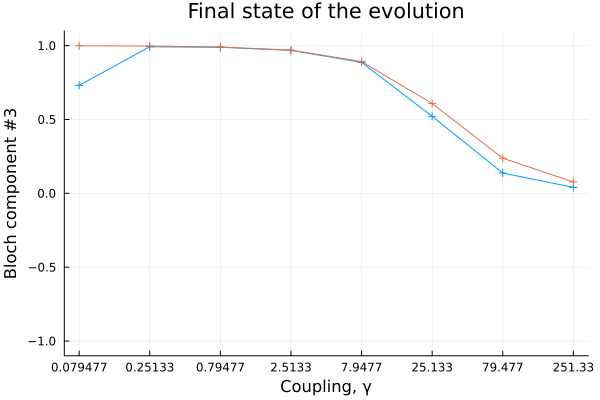

"c:\\Users\\Zakhar\\Documents\\GitHub\\OQSID-thesis\\THERMALIZATION\\final_bloch3.pdf"

In [12]:
plt = plot_bloch_ends("../DATA/ALL_GAMMAS_B4_D10.h5", 3)
display(plt)
savefig(plt, "final_bloch3.pdf")